In [510]:
# import the necessary packages
from skimage import exposure
import numpy as np
import argparse
import imutils
from ipywidgets import interact
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Load the image file

<IPython.core.display.Javascript object>


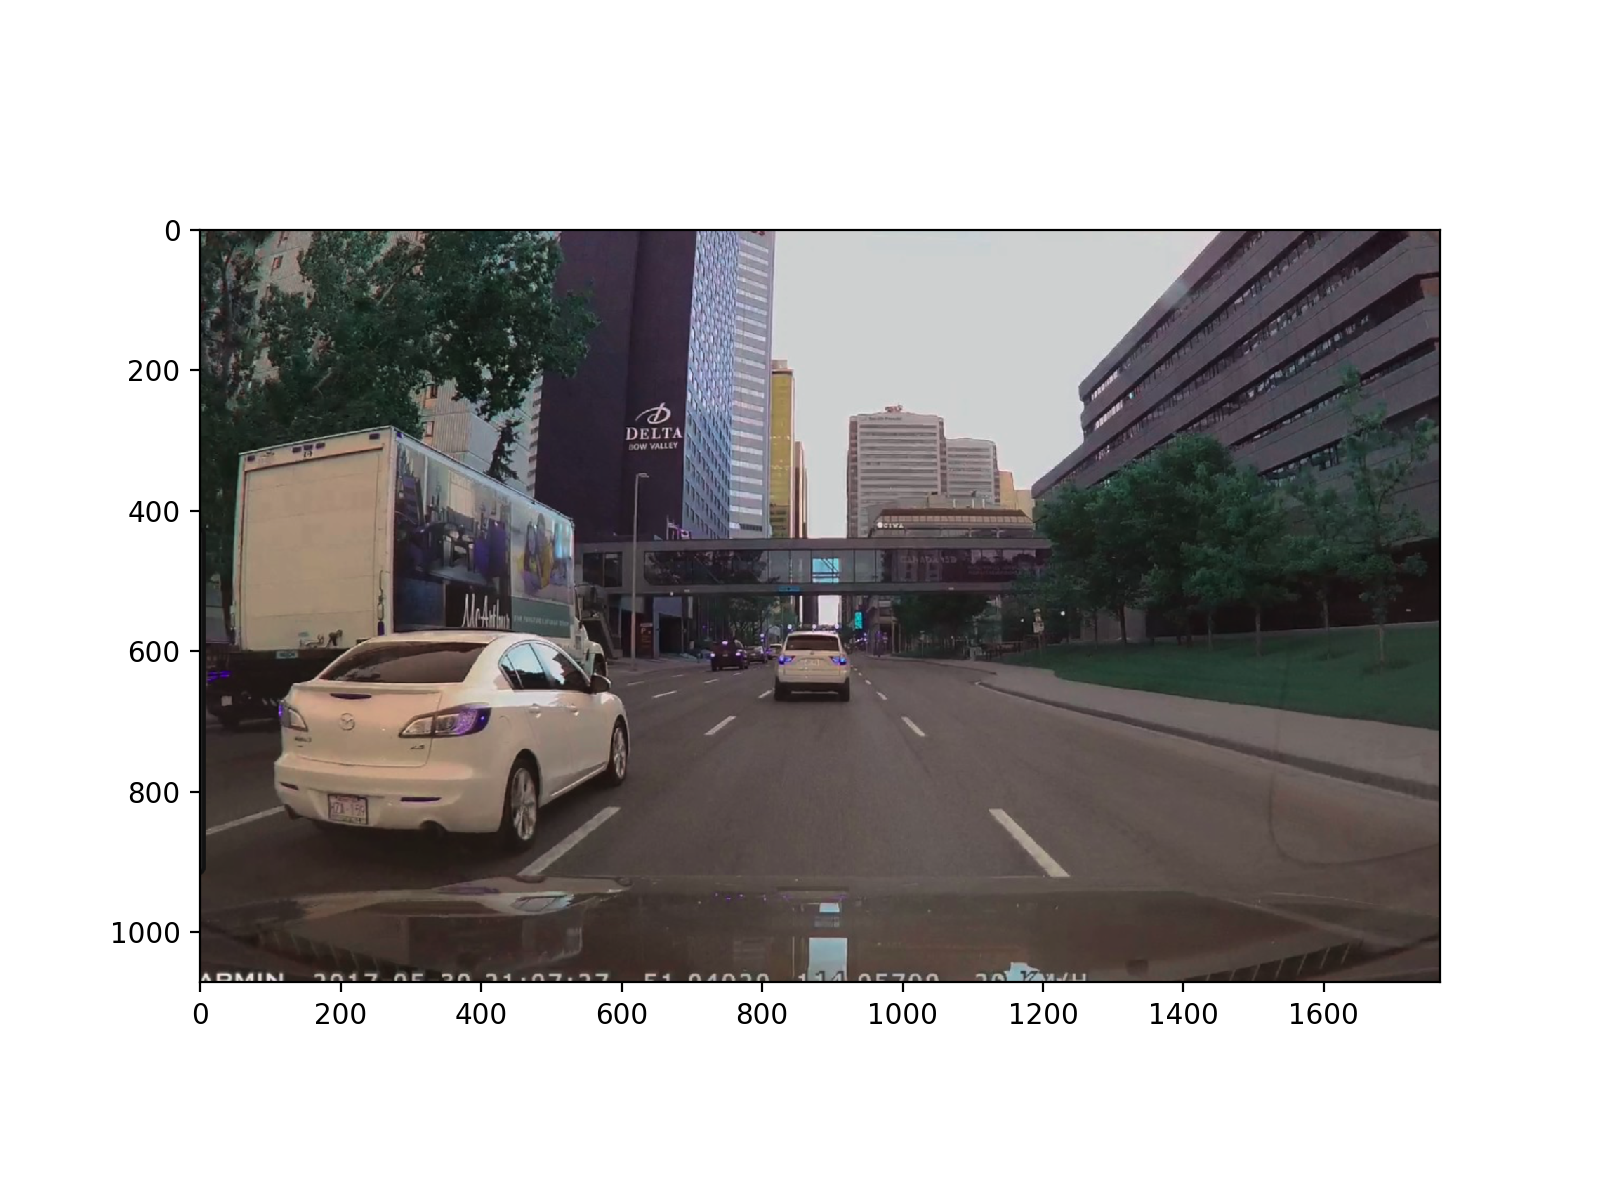

In [511]:
image = cv2.imread("/Users/edenmolina/Documents/Self_Driving_Car/Screen Shot 2019-02-12 at 11.04.01 AM.png")
# image = cv2.imread("/Users/edenmolina/Documents/Self_Driving_Car/0000000037.png")
# lateral_crop = 200
# image = image[:, lateral_crop:-(lateral_crop+30), :]
plt.figure(figsize=(8, 6))
plt.imshow(image)

# Draw a trapezoid on the image
This trapizoid will be the part of the image from which the scan lines will be caluclated.

In [512]:
def draw_trap(x1 = 1603, y1 = 1570, x2=735, y2=1992):
    y3 = y1
    y4 = y2
    x3 = image.shape[1]-x1
    x4 = x3+(x1-x2)

    fig = figure(figsize = (8,6))
    plt.imshow(image)
    plt.plot((x1, x2), (y1, y2), c= 'm', linewidth = 3)
    plt.plot((x2, x4), (y2, y4), c= 'm', linewidth = 3)
    plt.plot((x3, x4), (y3, y4), c= 'm', linewidth = 3)
    plt.plot((x3, x1), (y3, y1), c= 'm', linewidth = 3)

In [513]:
interact(draw_trap, x1 = (0, image.shape[0]), y1 = (0, image.shape[1]), x2 = (0, image.shape[0]), y2 = (0, image.shape[1]))

interactive(children=(IntSlider(value=1072, description='x1', max=1072), IntSlider(value=1570, description='y1…

<function __main__.draw_trap(x1=1603, y1=1570, x2=735, y2=1992)>

Final trapezoid values

In [514]:
x1 = 1603 
y1 = 1570 
x2 = 735
y2 = 1992
x3 = image.shape[1]-x1
y3 = y1
y4 = y2
x4 = x3+(x1-x2)

# x1 = 315 
# y1 = 215 
# x2 = 130
# y2 = 300
# x3 = image.shape[1]-x1
# y3 = y1
# y4 = y2
# x4 = x3+(x1-x2)

x1 = 770 
y1 = 670 
x2 = 521
y2 = 846
x3 = image.shape[1]-x1
y3 = y1
y4 = y2
x4 = x3+(x1-x2)

In [515]:
# The verticies of the trapezoid
# Starts at top left and moves cw
pt1 = np.array([[x1, y1],
                       [x3, y3],
                       [x4, y4],
                       [x2, y2]])

## Plot the finalized trapezoid onto the image

<IPython.core.display.Javascript object>


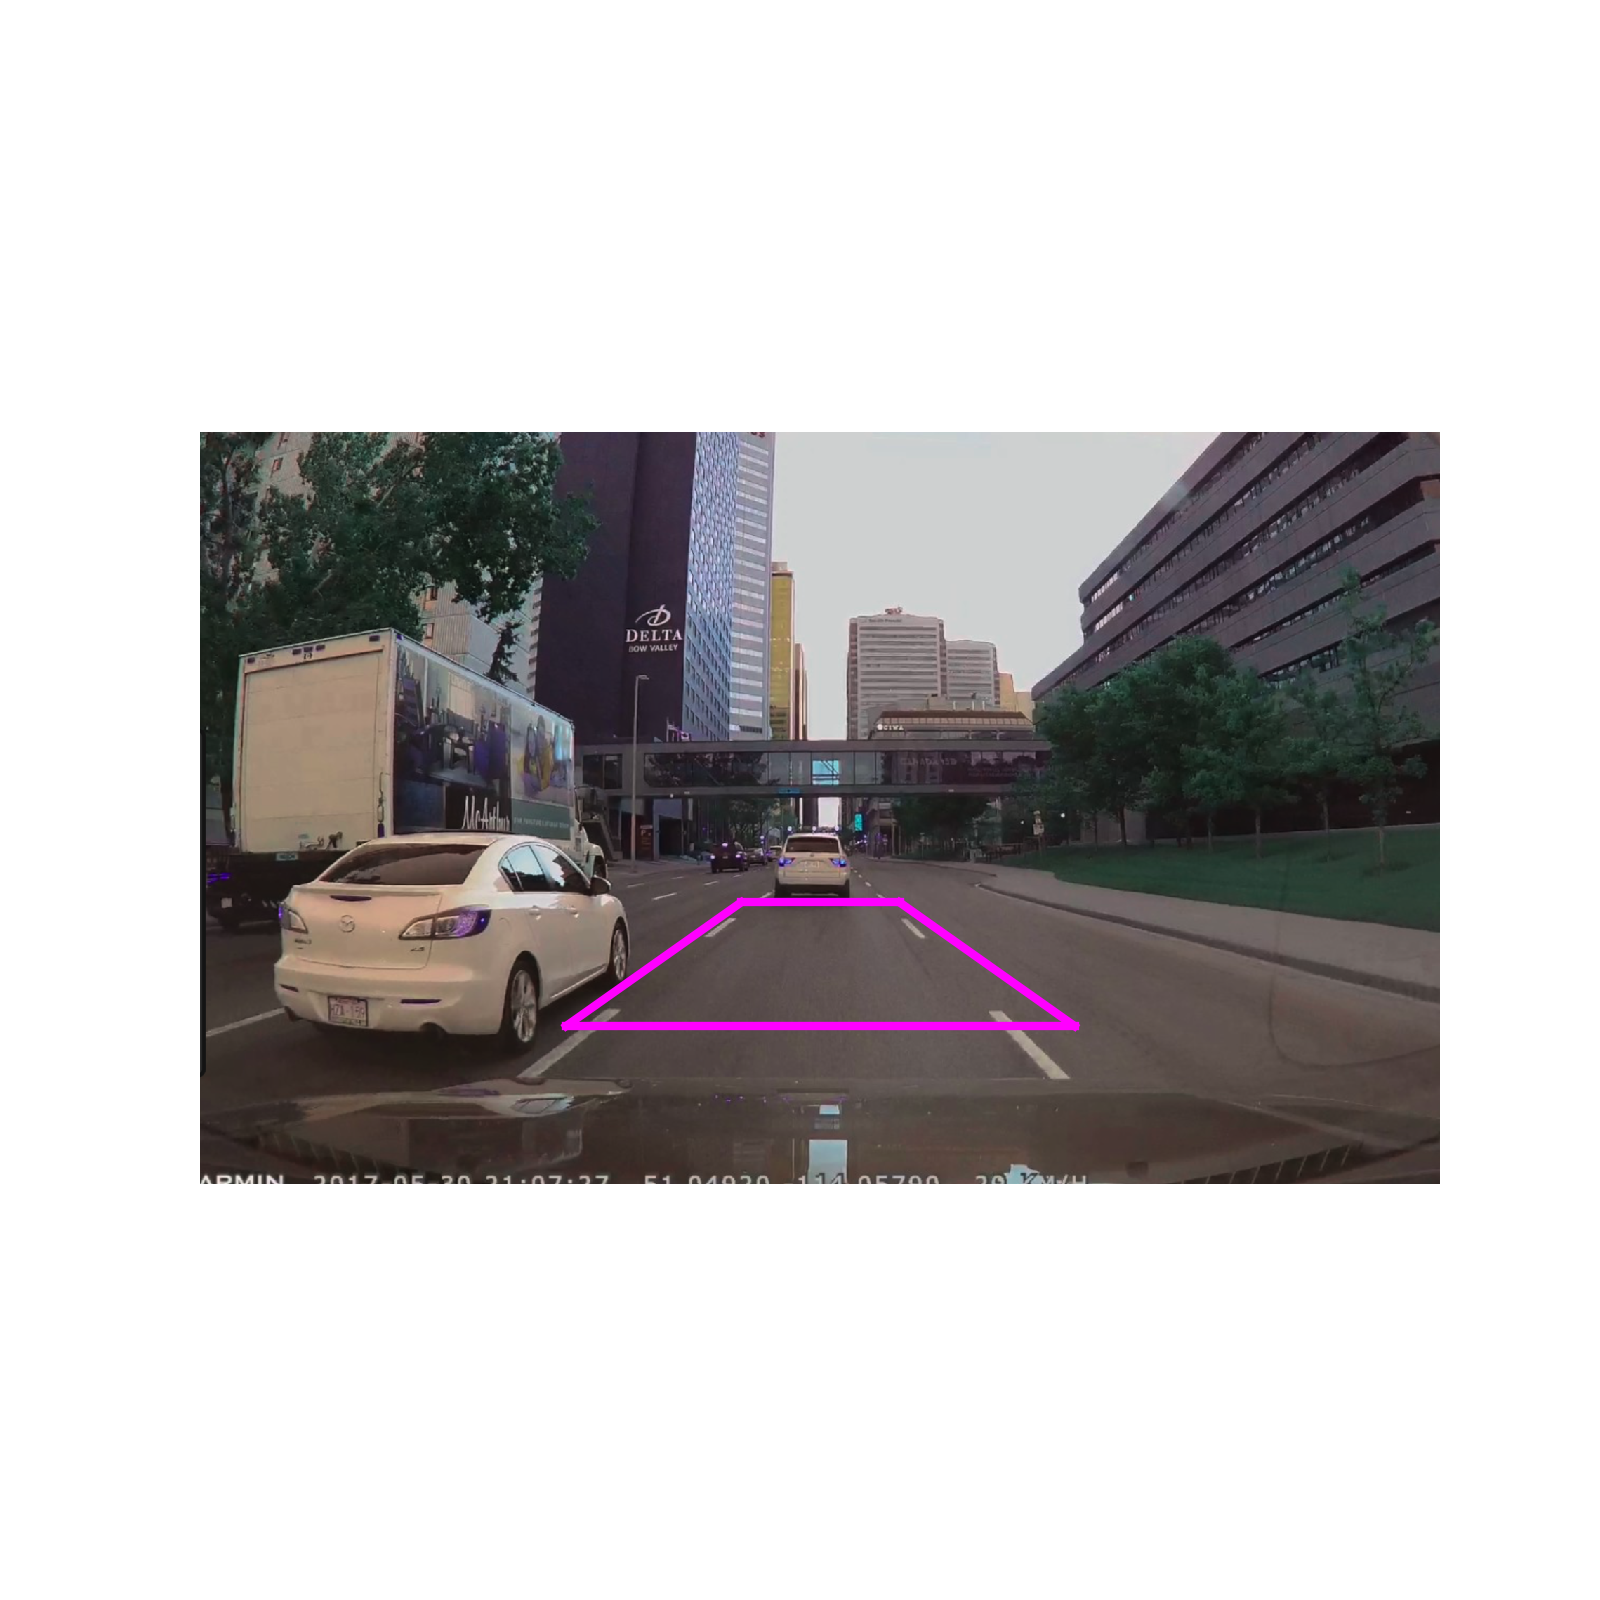

(-0.5, 1765.5, 1071.5, -0.5)

In [516]:
fig = figure(figsize = (8,8))
plt.imshow(image)
plt.plot((x1, x2), (y1, y2), c = [1, 0, 1], linewidth = 3)
plt.plot((x2, x4), (y2, y4), c = [1, 0, 1], linewidth = 3)
plt.plot((x3, x4), (y3, y4), c = [1, 0, 1], linewidth = 3)
plt.plot((x3, x1), (y3, y1), c = [1, 0, 1], linewidth = 3)
plt.grid(0)
plt.axis('off')

# Compute the homography to transform the image
We want to warp the part of the image in the trapezoid so that we can get a 'bird's eye view of it'.

In [517]:
# Compute the size of the final image based the
# shape of the trapezoid
width_list = list()
for i in range(len(pt1)):
    width_list.append(abs(pt1[0][0]-pt1[i][0]))
    
height_list = list()
for i in range(len(pt1)):
    height_list.append(abs(pt1[0][1]-pt1[i][1]))
maxWidth = max(width_list)
maxHeight = max(height_list)*2

These are the points onto which we will map the old points of the trapezoid.

In [518]:
# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
pt2 = np.array([
    [0, 0],[maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

Compute the transformation matrix and warp the image

In [519]:
matrix, status = cv2.findHomography(pt1, pt2)
warped = cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))

## Plot the warped image

<IPython.core.display.Javascript object>


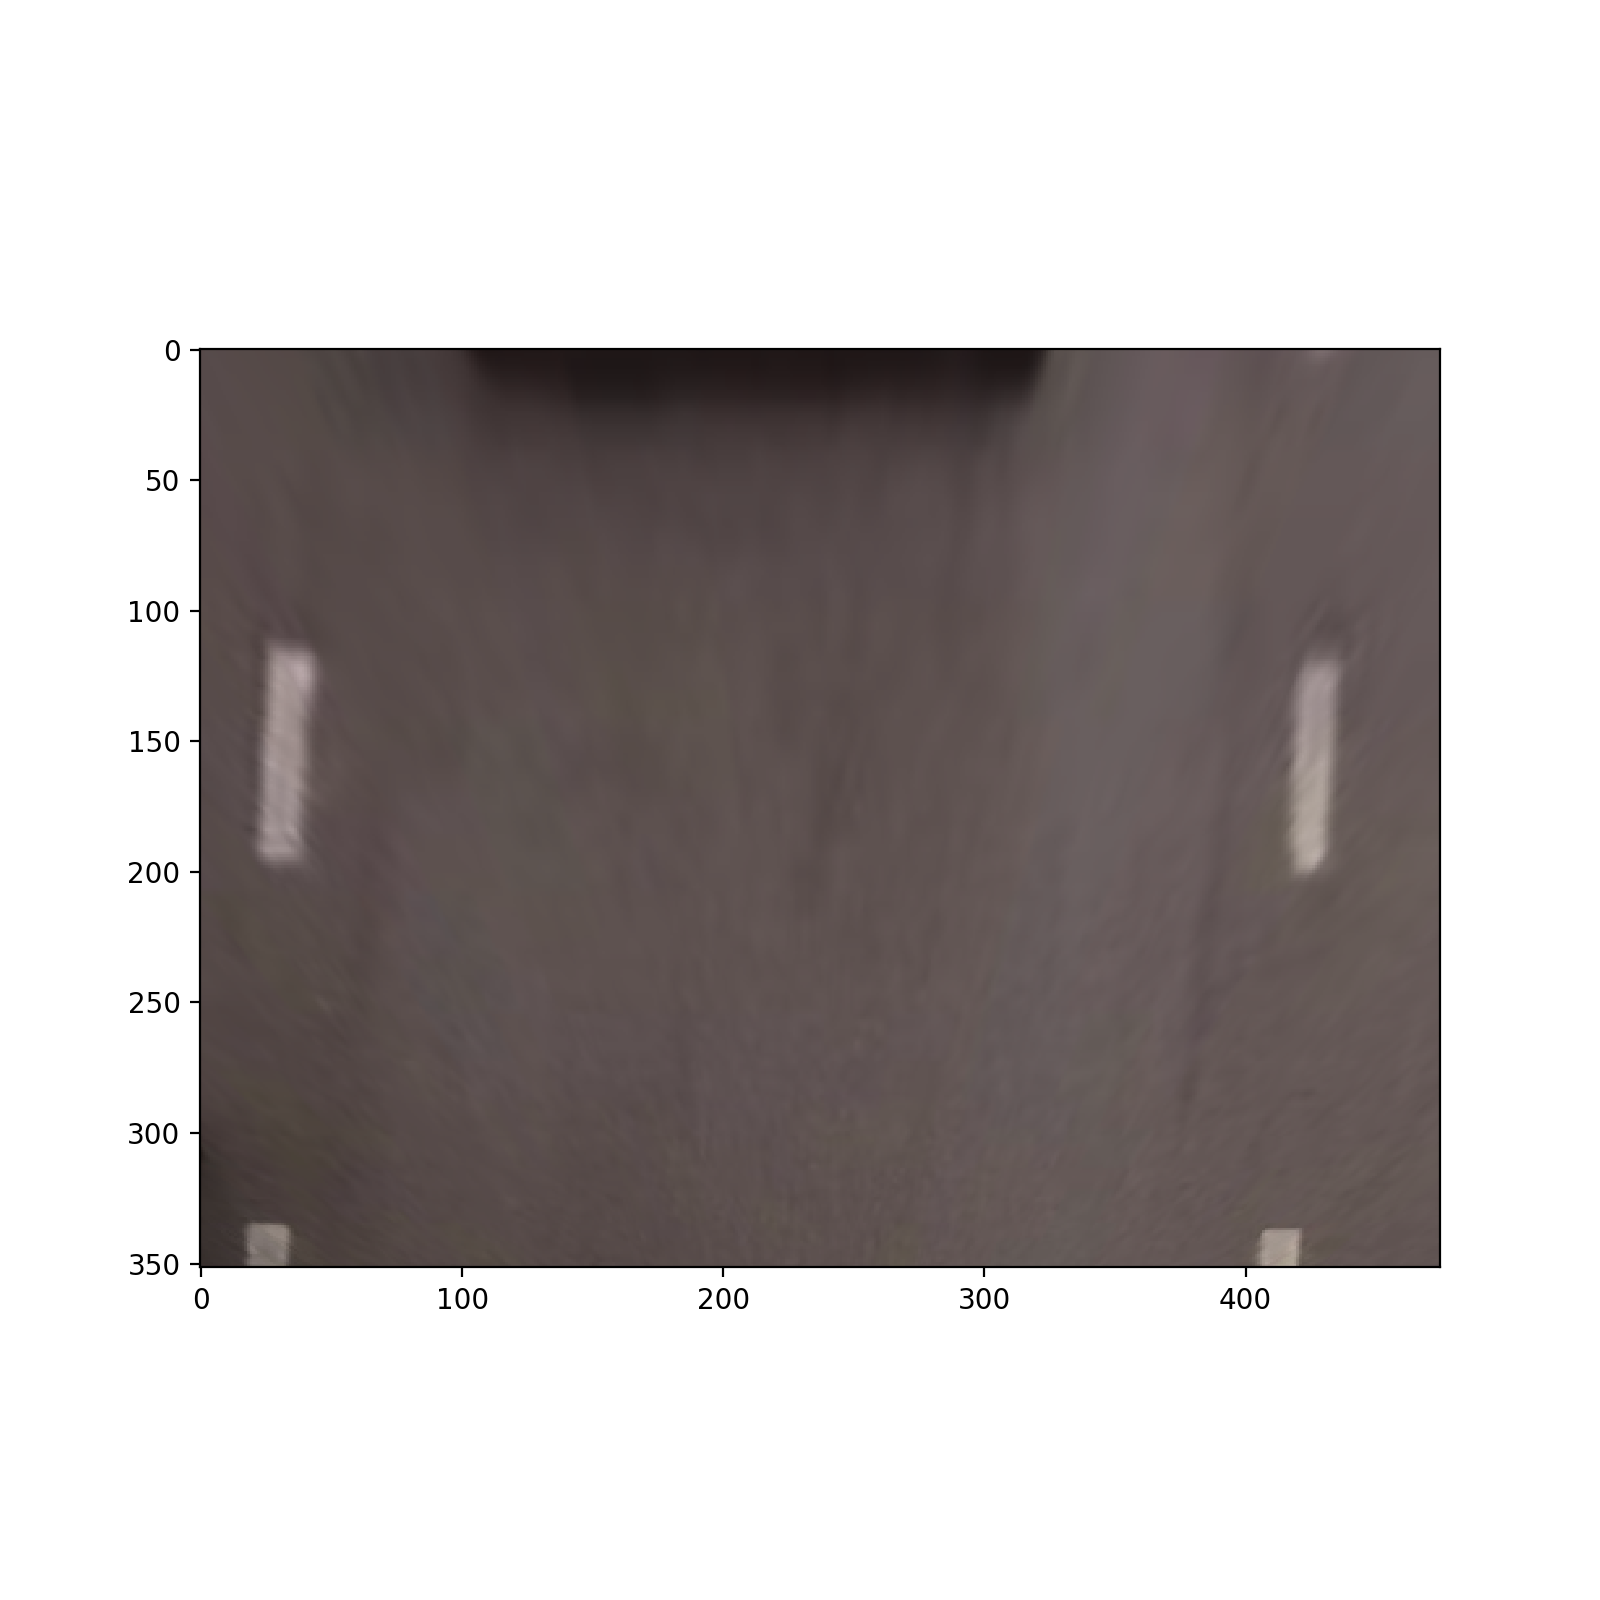

In [520]:
plt.figure( figsize = (8, 8))
plt.imshow(warped)

# Convert the image to grayscale and downsample

<IPython.core.display.Javascript object>


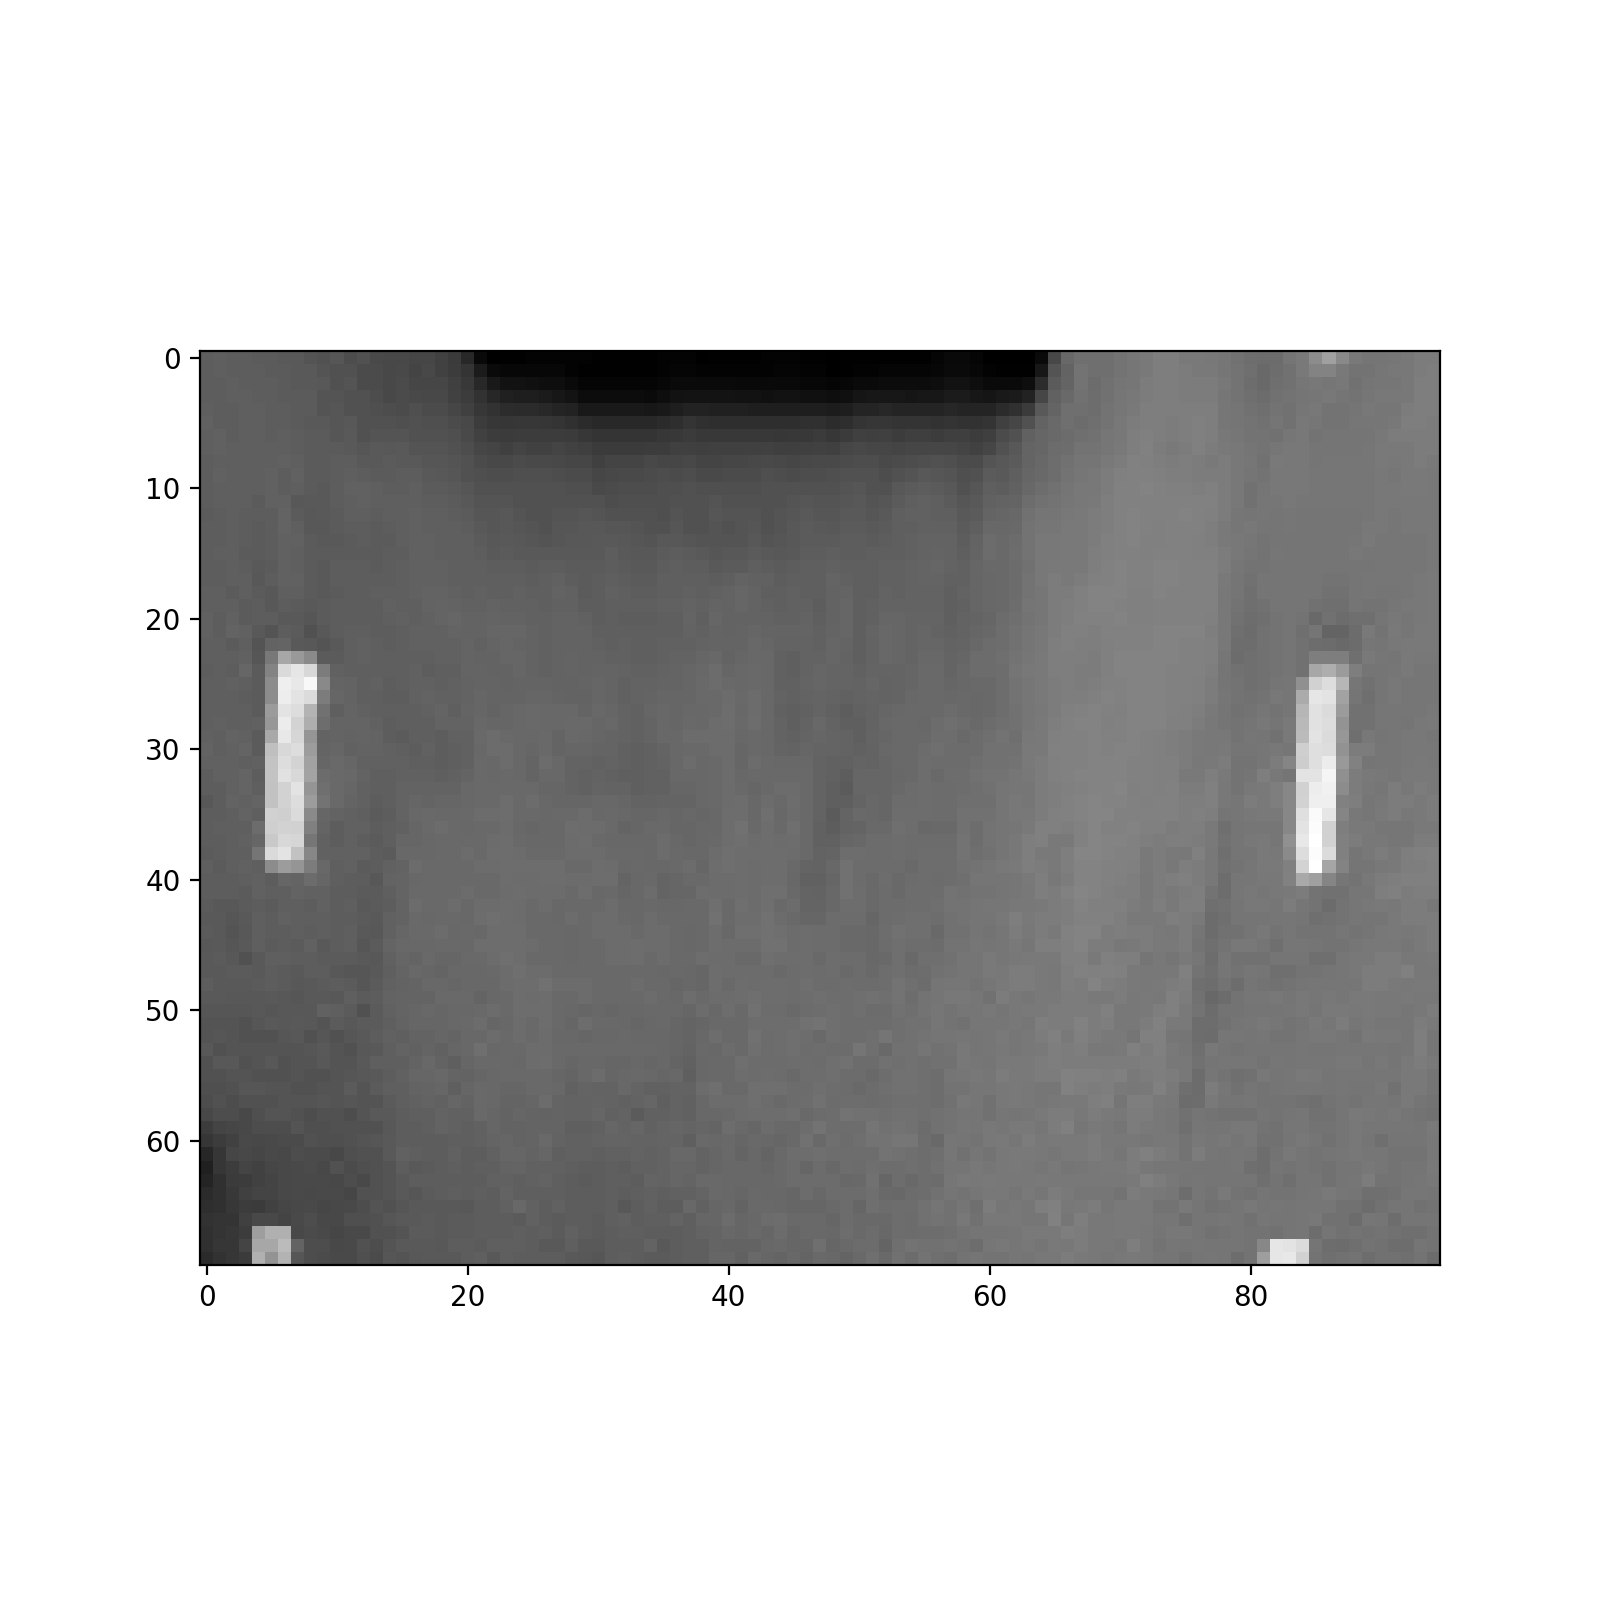

In [521]:
downsampling_factor = 5
new_size = tuple((np.array([warped.shape[1], warped.shape[0]])/downsampling_factor).astype('int'))

warped_small = cv2.resize(warped, new_size, interpolation = cv2.INTER_NEAREST)

warped_small_gray = cv2.cvtColor(warped_small, cv2.COLOR_BGR2GRAY)
warped_small_gray = warped_small_gray/np.sum(warped_small_gray)

plt.figure(figsize = (8, 8))
plt.imshow(warped_small_gray, cmap = 'gray')

In [329]:
# for i in range(np.shape(warped_gray)[0]):
#     warped_gray[i] = np.roll(warped_gray[i], 100)

In [522]:
def unroll_image(warped_small_gray, direction, R, k, x_padding = 64):
    '''
    Unroll warped_small_gray image. 
    direction = left or right
    R = radius of circle
    k = distance from top of image to car
    x_padding = amount of zeros padding on the left and right of warped_small_gray
    '''
    
    W = warped_small_gray.shape[1] #Image width
    H = warped_small_gray.shape[0] #Image heigth

    if direction == 'left':
        h = W/2 - R
    elif direction == 'right':
        h = W/2 + R
    else:
        print('direction not implemented')

    shifts = np.zeros(warped_small_gray.shape[0])
    for y in range(len(shifts)):
        if direction == 'right':
            shifts[y] = np.sqrt(R**2 - (y-k)**2) - R
        elif direction == 'left':
            shifts[y] = R - np.sqrt(R**2 - (y-k)**2)

    shifts = shifts.round().astype('int')

#     shifted_image = np.zeros_like(warped_small_gray)
    shifted_image = np.copy(warped_small_gray)
#     mask_small = np.zeros_like(warped_small_gray)
    mask_small = np.copy(warped_small_gray)

    for y in range(shifted_image.shape[0]):
        shifted_image[y] = np.roll(shifted_image[y], shifts[y])
#         shifted_image[y, x_padding+shifts[y]:-(x_padding-shifts[y])] = warped_small_gray[y, x_padding:-x_padding]
#         mask_small[y, x_padding+shifts[y]:-(x_padding-shifts[y])] = 255
        mask_small[y] = 255
        
    return shifted_image, mask_small

# Compute the scanline

In [523]:
def compute_scanline(shifted_image, mask_small, same_padding_columns = 5):
    '''
    Compute scanline and top 5 largest adjacent differences, and compute score
    same_padding_columns = number of columns to pad on each side of mask.
    '''

    overhead_nan_image = np.copy(shifted_image).astype('float32')
    overhead_nan_image[np.logical_not(mask_small)] = np.NaN

    #Add padding
    for i in range(overhead_nan_image.shape[0]):
        for j in range(overhead_nan_image.shape[1]-1):
            if np.isnan(overhead_nan_image[i, j]) and not np.isnan(overhead_nan_image[i, j+1]):
                overhead_nan_image[i, j-same_padding_columns:j+1] = overhead_nan_image[i, j+1]
                break;
            if not np.isnan(overhead_nan_image[i, j]) and np.isnan(overhead_nan_image[i, j+1]):
                overhead_nan_image[i, j:j+same_padding_columns] = overhead_nan_image[i, j]
                break;       
            
                
    scanline = np.sum(overhead_nan_image, axis = 0)

    scanline_trimmed = scanline[~np.isnan(scanline)]

    d = np.diff(scanline_trimmed.astype('float'))
    sI = argsort(abs(d)) 
    n = 5
    top_n = d[sI[-n:]]

    score = sum(abs(top_n))

    sI_shifted = np.where(~np.isnan(scanline))[0][sI]         
    
    return scanline, sI_shifted, score

<IPython.core.display.Javascript object>


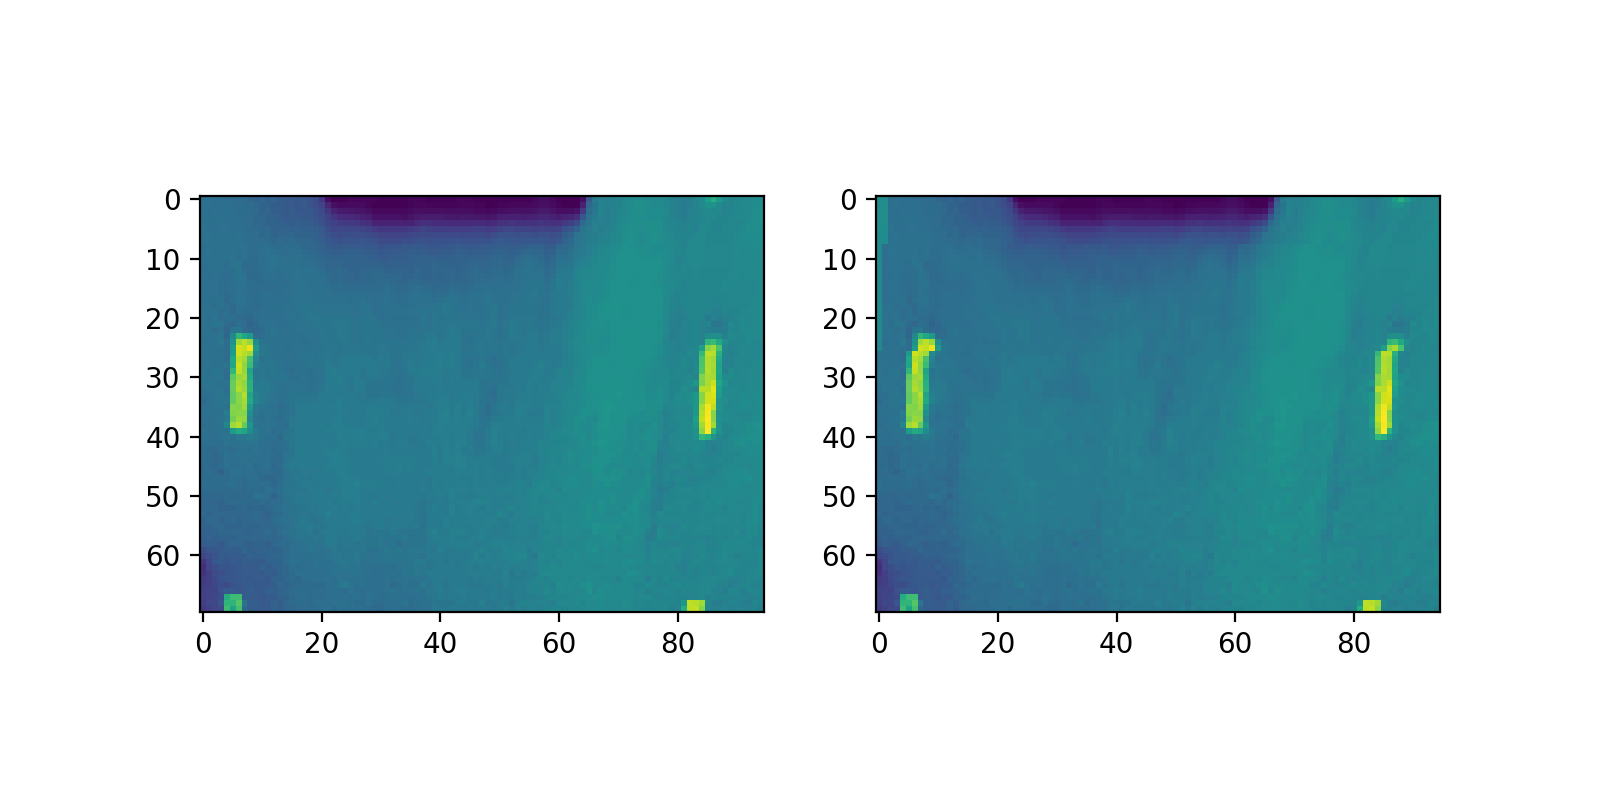

<IPython.core.display.Javascript object>


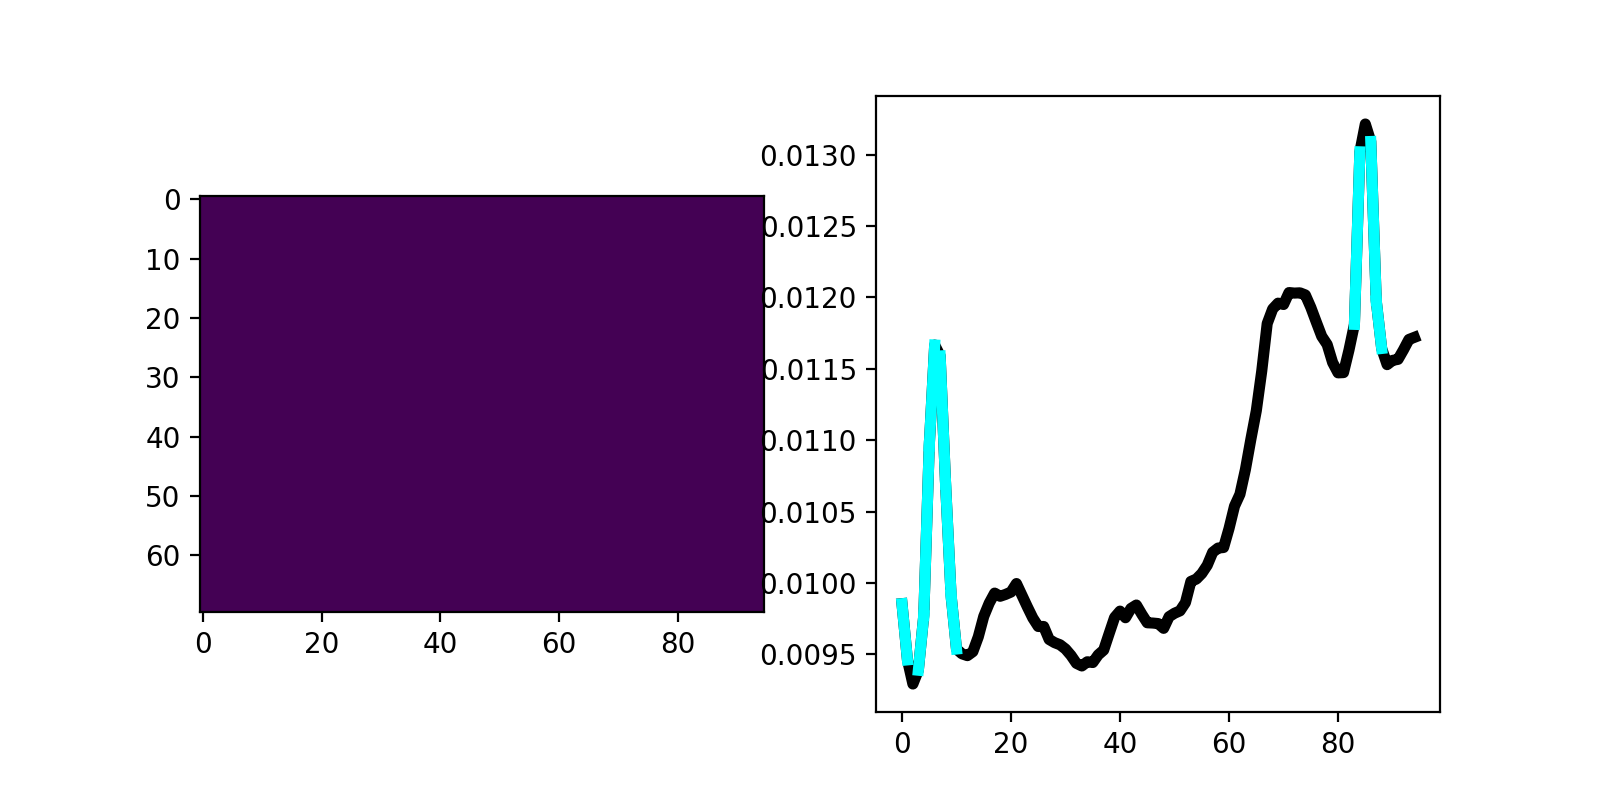

In [524]:
shifted_image, mask_small = unroll_image(warped_small_gray, 
                                         direction = 'left', 
                                         R = 600, 
                                         k = 50, 
                                         x_padding = int(warped_small_gray.shape[0]/2))


plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(warped_small_gray)
plt.subplot(122)
plt.imshow(shifted_image)

scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns = 5)

fig = figure(figsize = (8,4))

plt.subplot(121)
plt.imshow(mask_small)
plt.subplot(122)
plt.plot(scanline, linewidth = 4.0, color = 'k')

n = 10
for top_index in sI_shifted[-n:]:
    plot((top_index, top_index + 1) , 
         (scanline[top_index], scanline[top_index+1]), c = [0, 1, 1], linewidth= 4)

# plt.axis('off')
# plt.ylim(0, 16000)

# Test different curvatures

In [531]:
k = 50

In [532]:
def one_over_mapping(start, end, numpoints):
    start_inverse = 1.0/start
    end_inverse = 1.0/end
    
    inverse_points = np.linspace(start_inverse, end_inverse, numpoints)
    return 1.0/inverse_points

In [533]:
# For the sake of simplicity, assume 1 m = 1 pixel 
def find_optimal_unwrapping(warped_small_gray, steps = 512, min_radius = 100, max_radius = 1e4, same_padding_columns = 5):
    
    # Curvature Hypotheses
    radii = np.concatenate((one_over_mapping(min_radius, max_radius, steps), [1e6], one_over_mapping(max_radius, min_radius, steps)))

    directions = ['right']*(steps+1)
    directions.extend(['left']*steps)

    scores = []

    for i, R in enumerate(tqdm(radii)):

        direction = directions[i]

        shifted_image, mask_small = unroll_image(warped_small_gray, 
                                                 direction = direction, 
                                                 R = R, 
                                                 k = k, 
                                                 x_padding = int(warped_small_gray.shape[0]/2))

        scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns)

        scores.append(score)

    scores = np.array(scores)
    winning_index = np.argmax(scores)
    
    R = radii[winning_index]
    direction = directions[winning_index]
    
    shifted_image, mask_small = unroll_image(warped_small_gray, 
                                             direction = direction, 
                                             R = R, 
                                             k = k, 
                                             x_padding = int(warped_small_gray.shape[0]/2))
 
    scanline, sI_shifted, score = compute_scanline(shifted_image, mask_small, same_padding_columns)
    
    return shifted_image, mask_small, scanline, sI_shifted, scores


In [534]:
shifted_image, mask_small, scanline, sI_shifted, scores = find_optimal_unwrapping(warped_small_gray, 
                                                                                  steps = 10, 
                                                                                  min_radius = 50, 
                                                                                  max_radius = 1e4)

100%|██████████| 21/21 [00:00<00:00, 37.71it/s]


<IPython.core.display.Javascript object>


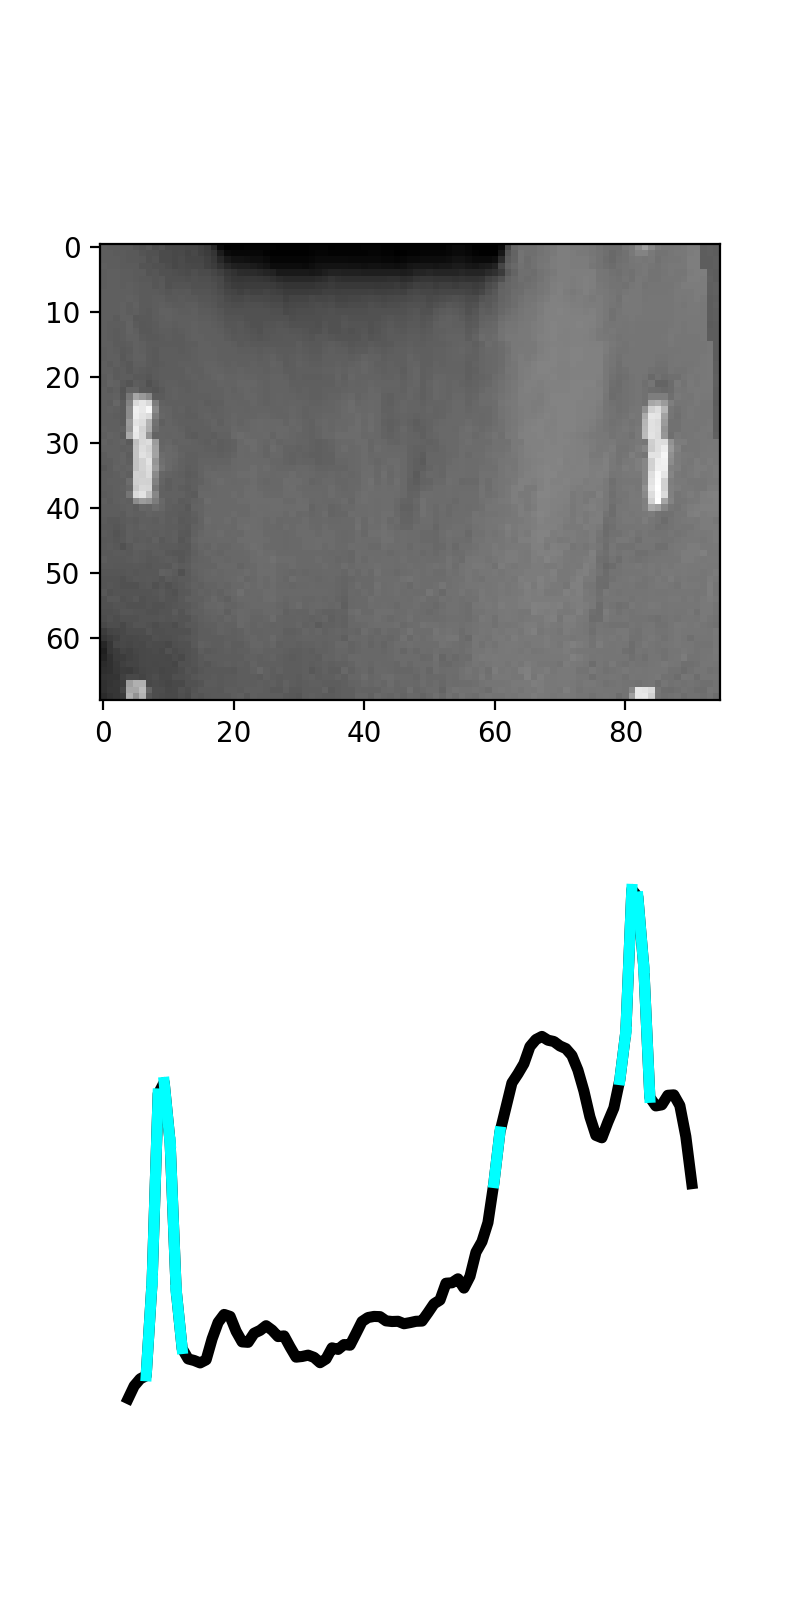

(-4.7, 98.7, 0.008900926727801562, 0.013597349356859922)

In [535]:
fig = figure(figsize = (4,8))
plt.subplot(2,1,1)
plt.imshow(shifted_image, cmap = 'gray')

plt.subplot(2,1,2)
plt.plot(scanline, linewidth = 4.0, color = 'k')

n = 10
for top_index in sI_shifted[-n:]:
    plt.plot((top_index, top_index + 1) , 
         (scanline[top_index], scanline[top_index+1]), c = [0, 1, 1], linewidth= 4)

plt.axis('off')
# plt.ylim(0, 16000)
#savefig('exports/p_34/scanlines/p_34_scanline_' + str(i).zfill(3) + '.png', transparent = True, dpi = 100)

<IPython.core.display.Javascript object>


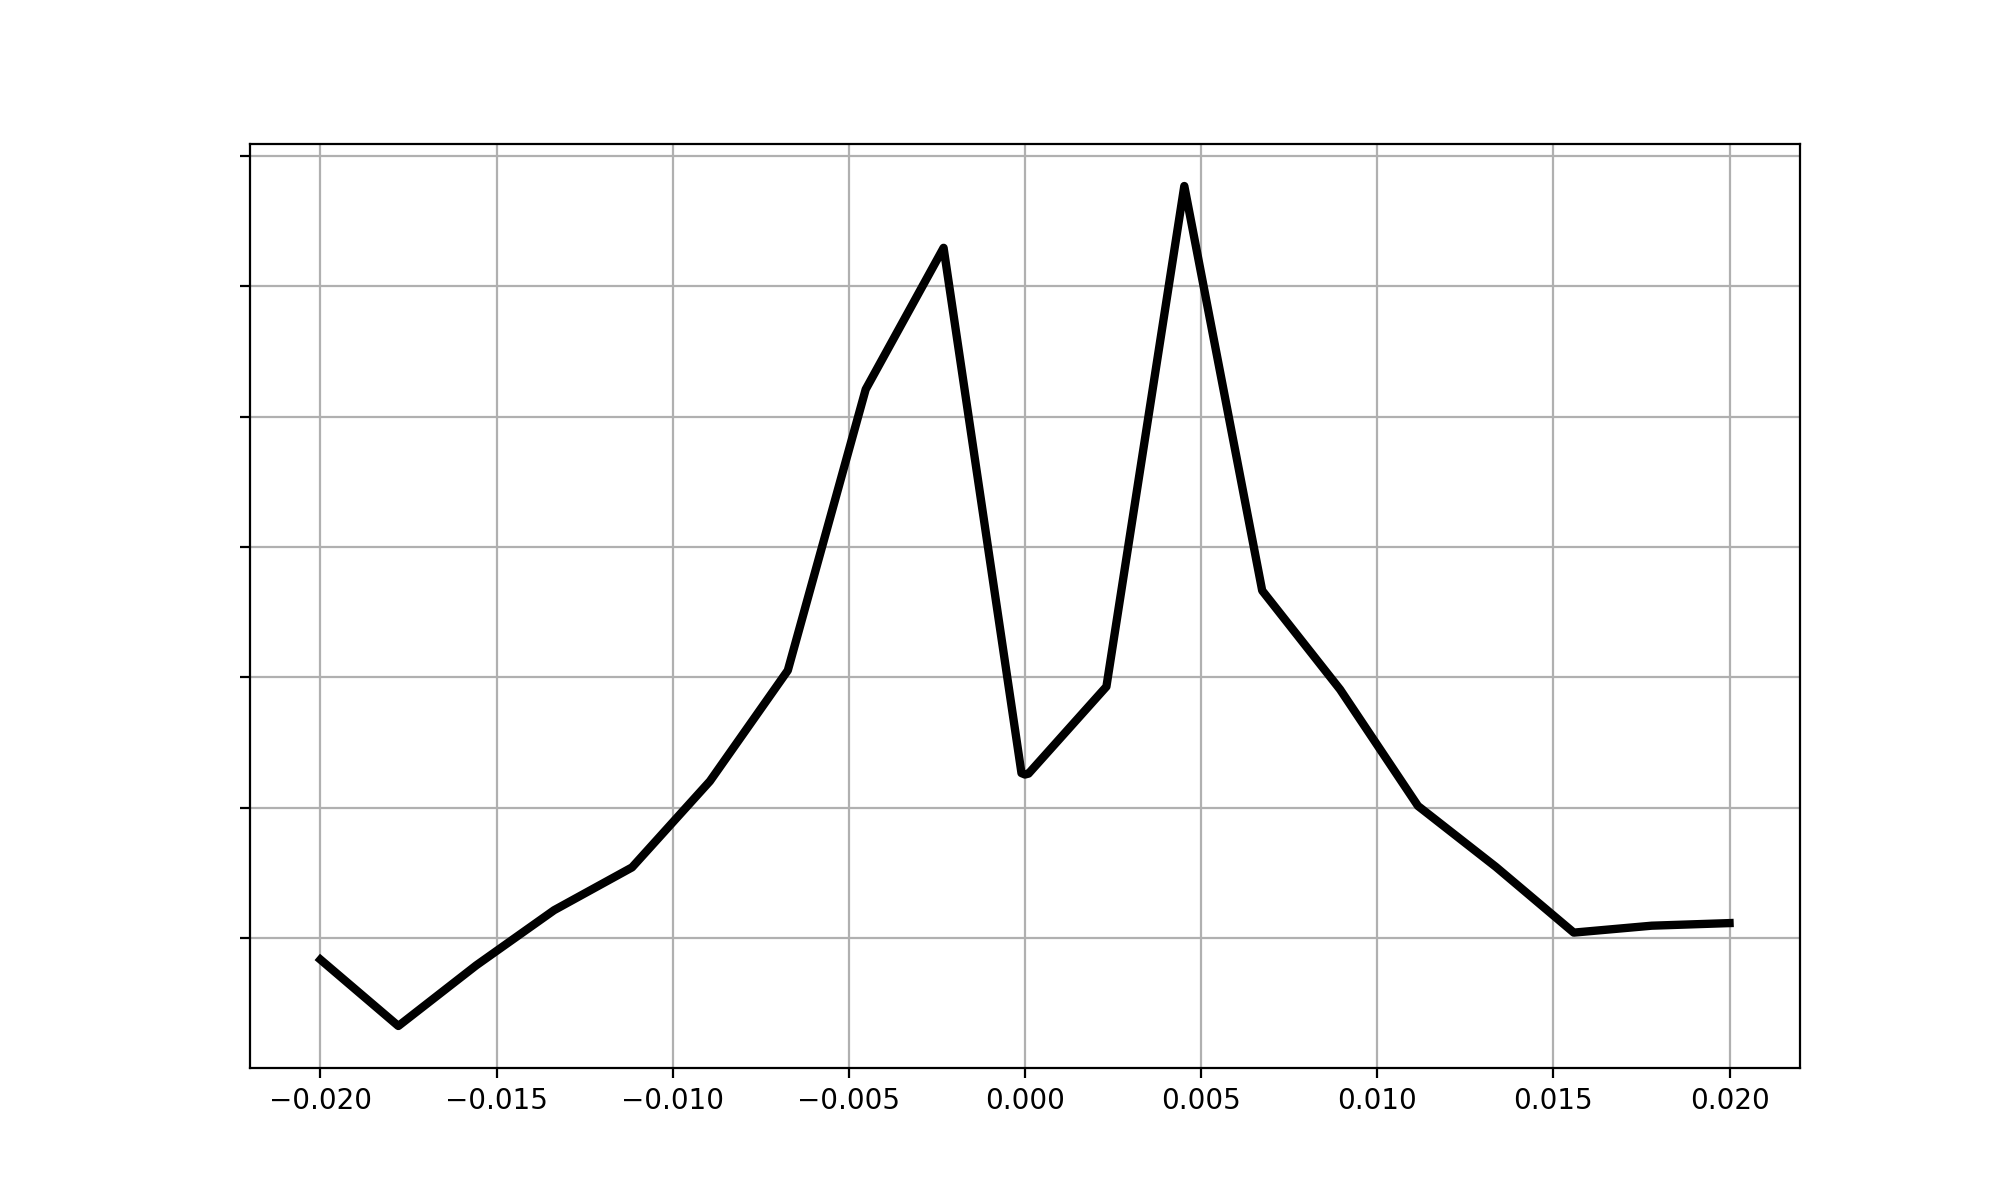

In [487]:
steps = 10
min_radius = 50
max_radius = 1e4
radii = np.concatenate((one_over_mapping(min_radius, max_radius, steps), [1e6], one_over_mapping(max_radius, min_radius, steps)))
directions = ['right']*(steps+1)
directions.extend(['left']*steps)


fig = figure(figsize = (10,6))
ax = fig.add_subplot(111)
abscissa = 1/radii 
abscissa[np.array(directions)=='right'] = abscissa[np.array(directions)=='right']*-1

plt.plot(abscissa[:len(scores)], scores, linewidth = 3, c = 'k')

plt.grid(1)
# ax.tick_params(labelbottom=False)  
ax.tick_params(labelleft=False)  
# xlim([-0.007, 0.007])

In [536]:
radii_inv = abscissa[:len(scores)]
radii_optimal = 1/radii_inv[np.argmax(scores)]
print ("The most optimal radii is: ", round(radii_optimal,2), round(radii_inv[np.argmax(scores)],4))

The most optimal radii is:  -432.69 -0.0023
